In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.datamodule import MSDataModule
from src.model import MSTransformer

[last_ckpt] = !ls -t1 ./lightning_logs/version_17869980/checkpoints/*.ckpt | head -n1
print(last_ckpt)

model = MSTransformer.load_from_checkpoint(last_ckpt)
dm = MSDataModule(**dict(model.hparams))

# dm.prefetch = False

dm.setup()
model = model.cpu()
model.eval();

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./lightning_logs/version_17869980/checkpoints/epoch=92-step=114948-best.ckpt


In [4]:
len(dm.train_dataset), len(dm.val_dataset), len(dm.test_dataset)

(2528518, 149737, 301754)

In [29]:
from src.baselines import CARPPretextModel

carp = CARPPretextModel()
carp.eval();

In [33]:
from sequence_models.pretrained import load_model_and_alphabet

model, collater = load_model_and_alphabet('carp_38M')

In [26]:
from tqdm import tqdm

from src.constants import MSConstants
C = MSConstants()

embeddings = []
sequences = []
charges = []
ces = []
spectra = []

masked_aas = []
pred_aas = []
carp_aas = []
has_ptm = []

for i, batch in tqdm(enumerate(dm.val_dataloader())):
    x = batch['x'].to(model.device)
    x_mask = batch['x_mask'].to(model.device).unsqueeze(-1)
    z = model.x_encoder(x, x_mask)
    z = (z * x_mask).sum(1) / x_mask.sum(1)
    z = z.detach().cpu().numpy()
    embeddings.append(z)
    
    sequences += batch['sequence']
    
    x_pred, masking_idx = model.predict_step(batch, i)
    
    idxs = masking_idx.detach().cpu().numpy()
    seqs = []
    for seq, idx in zip(batch['sequence'],idxs):
        seq = seq[:idx] + '#' + seq[idx+1:]
        has_ptm.append(('c' in seq) or ('m' in seq))
        seq = seq.upper()
        seqs.append(seq)
    
    masked_aa = x[range(len(x)),masking_idx].detach().cpu().numpy()
    masked_aas += [C.alphabet[i] for i in masked_aa]
    
    pred_aa = x_pred[range(len(x)),masking_idx].detach().cpu().numpy()
    pred_aas += [C.alphabet[i] for i in pred_aa]
    
    carp_aa = carp.predict(seqs)
    carp_aas += [seq[idx] for seq,idx in zip(carp_aa,idxs)]

embeddings = np.concatenate(embeddings,0)

embeddings = pd.DataFrame(embeddings)
embeddings = embeddings.groupby(sequences).mean()
embeddings.shape

292it [02:51,  1.70it/s]


(23155, 128)

<AxesSubplot:>

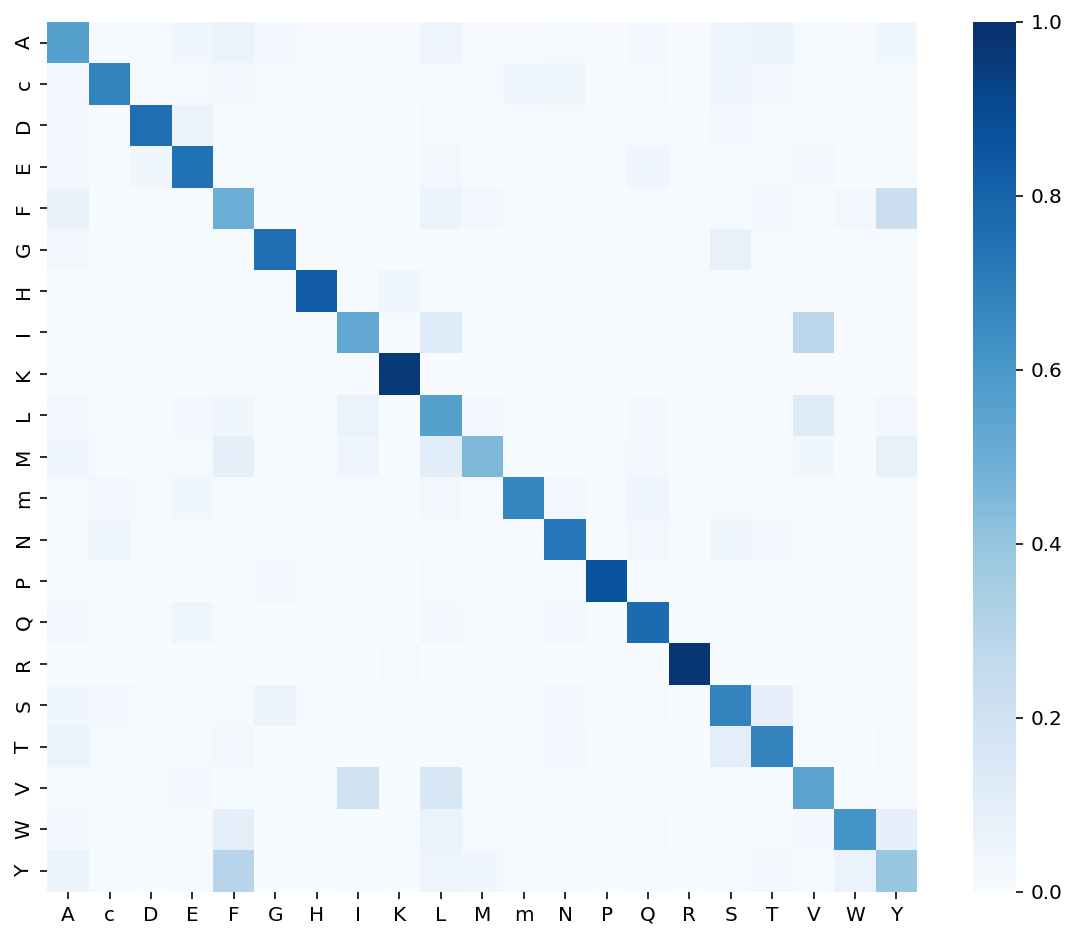

In [27]:
# accuracy per AA

from sklearn.metrics import confusion_matrix
from collections import defaultdict, Counter

mat = defaultdict(Counter)
for x, x_pred in zip(masked_aas, pred_aas):
    mat[x][x_pred] += 1
mat = pd.DataFrame(mat)
mat = mat.sort_index(key=lambda s:s.str.lower()).T
mat = mat.sort_index(key=lambda s:s.str.lower()).T
mat = mat.fillna(0).astype(int)

mat = mat / mat.sum(1).values[:,None]

plt.figure(figsize=(10,8))
sns.heatmap(mat,annot=False,fmt='d',cmap='Blues',square=True,vmin=0,vmax=1)

In [ ]:
# physically similar AAs tend to get confused: branched chain (ILV), aromatic (FY)
# m and M don't get confused much

In [ ]:
def polarity(sequence):
    is_basic = np.array([aa in 'RHK' for aa in sequence])
    polarity = (is_basic * np.arange(len(sequence))).sum() / np.arange(len(sequence)).sum()
    return polarity

import scanpy as sc

adata = sc.AnnData(embeddings)

adata.obs['sequence'] = embeddings.index
adata.obs['length'] = adata.obs['sequence'].map(len)
adata.obs['first_aa'] = adata.obs['sequence'].str[0]
adata.obs['second_aa'] = adata.obs['sequence'].str[1]
adata.obs['last_aa'] = adata.obs['sequence'].str[-1]
adata.obs['num_basic'] = adata.obs['sequence'].map(lambda s: sum([c in 'RKH' for c in s])).astype(str)
adata.obs['polarity'] = adata.obs['sequence'].map(polarity)

In [ ]:
# from scipy.stats import entropy
# adata.obs['peak_entropy'] = [entropy(s.ravel())/s.shape[0] for s in spectra]
# adata.obs['bond_entropy'] = [entropy(s.sum((1,2,3)).ravel())/s.shape[0] for s in spectra]
# adata.obs['terminality'] = [s.sum((0,2,3))[-1]/s.sum() for s in spectra]

In [ ]:
# # sc.pp.subsample(adata,fraction=0.25)

# from src.cdhit import CDHIT

# clusters = CDHIT(threshold=0.9, word_length=5).fit_predict(adata.obs['sequence'])

# adata = adata[adata.obs[[]].groupby(clusters).head(3).index]

len(adata)

In [ ]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)
sc.tl.umap(adata, random_state=0)
sc.tl.leiden(adata, resolution=0.5)

In [ ]:
sc.pl.umap(adata,color=['length','num_basic'])
sc.pl.umap(adata,color=['first_aa','last_aa'])
# sc.pl.umap(adata,color=['bond_entropy','terminality'])

Do sequences within sequence-similarity clusters tend to be closer in fragment space? (IOW: "do distances in 'fragmentation space' have anything to do with edit distance?")

The more interesting question is the other way around. "Do sequences nearby in fragment space tend to be similar?"

In [ ]:
# from src.cdhit import CDHIT
# from sklearn.metrics import pairwise_distances

# cdhit = CDHIT(
#     threshold=0.9,
#     word_length=5
# )
# clusters = np.array(cdhit.fit_predict(sequences))

# X = embeddings.values.copy()

# mean_dists = []
# for i, c in enumerate(clusters):
#     dists = pairwise_distances(X[clusters==c], X[[i]])
#     dists = sorted(dists.ravel())[1:]
#     if len(dists)==0:
#         continue
#     mean_dists.append(np.mean(dists))
    
# npr.seed(0)
# X = X[npr.permutation(X.shape[0])]

# rand_dists = []
# for i, c in enumerate(clusters):
#     dists = pairwise_distances(X[clusters==c], X[[i]])
#     dists = sorted(dists.ravel())[1:]
#     if len(dists)==0:
#         continue
#     rand_dists.append(np.mean(dists))
    
# plt.hist([mean_dists,rand_dists],bins=50,histtype='step');

# If I rank all other sequences by distance to this one, what's the average rank of other sequences in the same CDHIT cluster? Is it any different than if clusters were assigned randomly?

# X = embeddings.values.copy()

# npr.seed(0)

# from collections import Counter
# cluster_counts = Counter(clusters)

# mean_ranks = []
# rand_ranks = []
# for i, c in tqdm(enumerate(clusters)):
#     if cluster_counts[c]==1:
#         continue
#     dists = pairwise_distances(X, X[[i]]).ravel()
#     dists[i] = np.inf
#     ranks = np.argsort(dists)*1.
#     ranks[-1] = np.nan
#     mean_ranks.append(np.nanmean(ranks[clusters==c]))
#     rand_ranks.append(np.nanmean(ranks[clusters[npr.permutation(len(clusters))]==c]))
    
# plt.hist([mean_ranks,rand_ranks],bins=50,histtype='step');

# plt.figure(figsize=(8,4))
# sns.violinplot(
#     data=adata.obs,
#     x='leiden',
#     y='length',
#     order=adata.obs.groupby('leiden')['length'].mean().sort_values().index
# )

# adata = adata[adata.obs['length']==11]

# sc.tl.pca(adata, random_state=0)
# sc.pp.neighbors(adata, random_state=0)
# sc.tl.umap(adata, random_state=0)
# sc.tl.leiden(adata,resolution=0.25, random_state=0)

# adata.obs['pc1'] = adata.obsm['X_pca'][:,0]
# adata.obs['pc2'] = adata.obsm['X_pca'][:,1]

# adata

# sc.pl.umap(adata,color=['leiden','bond_entropy','num_basic'])
# # sc.pl.umap(adata,color=['first_aa','second_aa'])
# # sc.pl.umap(adata,color=['pc1','pc2'])

# Polarity still dominates.

# def plot_cluster(cluster, ax, vmax):
#     df = pd.DataFrame(adata.obs.query(f'leiden=="{cluster}"')['sequence'].str.split('').tolist()).iloc[:,1:-1]
#     df = df.apply(lambda c: c.value_counts())
#     df = df.join(pd.Series({aa:0 for aa in model.residues[1:]},name='aa'),how='outer').drop(columns=['aa']).drop(index=['C','O'])
#     df = df.fillna(0).astype(int)
#     df.columns.name = 'position'
#     plt.sca(ax)
#     sns.heatmap(df,vmin=0,vmax=vmax,cmap='Reds')
#     plt.title(f'cluster {cluster}')

# fig,axs = plt.subplots(1,2,figsize=(16,6))
# plot_cluster(3, axs[0], 50)
# plot_cluster(7, axs[1], 50)


